In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
model = SamModel.from_pretrained("ayoubkirouane/Breast-Cancer_SAM_v1").to(device)

In [ ]:
def run(input_boxes ,device ) :
  # prepare image + box prompt for the model
  inputs = processor(image, input_boxes=[[input_boxes]], return_tensors="pt").to(device)
  # forward pass
  # note that the authors use `multimask_output=False` when performing inference
  with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)
  # apply sigmoid
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
  medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
  return medsam_seg

In [ ]:
def draw_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


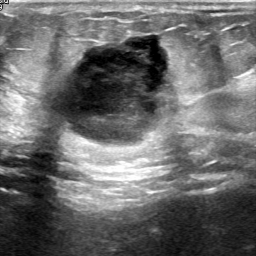

In [ ]:
img_path = "/content/download.png"
image = Image.open(img_path).convert("RGB")
input_boxes = [48, 27, 192, 168]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
medsam_seg = run(input_boxes ,device )
fig, axes = plt.subplots()

axes.imshow(np.array(image))
draw_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")
plt.savefig("output.png", bbox_inches="tight", pad_inches=0)